# 들어가며
* torch.autograd는 NN학습을 지원하는 torch의 자동 미분 엔진.
* 본 notebook에선 autograd가 NN학습에 어떻게 관여하는지 개념을 잡아본다.

## 1. 배경
NN(신경망)은 입력된 데이터에 대해 실행되는 nested 함수들의 모음이다. 이 함수들은 weight와 bias로 구성되어있다. (예로 conv()는 사실 filter들의 모임)이지.

학습은 2단계로 이루어진다:
* 순전파(Forward Propagation): 정답(GT)를 맞추기 위한 최선의 추측. 입력데이터가 각함수들을 타며 계산됨.
* 역전파(Backward Propagation): 추측값에서 발생한 error에 비례하여 매개변수(weight)를 조절함. 방법은 오류에 대한 함수들의 weight들의 미분값(gradient, 변화정도)를 수집하고, 경사하강법(gradient descent)를 사용하여 weight들을 최적화 한다.

## 2. torch에서 사용법
* 예제: resnet18, (64, 64, 3)이미지와 (1, 1000)label을 랜덤으로 생성.
* resnet pretrained model은 ImageNet 1000개 클래스임

In [15]:
import torch, torchvision

model = torchvision.models.resnet18(pretrained=True)
data = torch.rand(1, 3, 64, 64) # B, C, H, W
labels = torch.rand(1, 1000)

### 순전파

In [16]:
prediction = model(data)
prediction.shape

torch.Size([1, 1000])

### 오차 계산 및 역전파
오차 텐서에 `backward()`호출시 역전파 시작됨. 그다음 Autograd가 parameter(weight, bias)의 `.grad` 속성에 gradient를 계산하고 저장

In [17]:
# 오해 말자. torch의 classification loss함수(crossentropy)는 내부에 one_hot + softmax가 있으므로 벡터가 아닌 scalar로 들어간다.
loss = (prediction - labels).sum()
loss.backward()

In [18]:
# optimizer 정의 : SGD, momentum
optim = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

In [14]:
# 경사하강법(gradient descent) 시작. 이때 optimizer는 parameter.grad에 저장된 gradient에 따라 매개 변수를 업데이트
optim.step()

----------------
# Autograd 동작 세부 내용 (건너 뛰어도 된다고 하나 필요하다 싶은것만 선별)

## 3. autograd의 미분
* `.backward()`시, 각 연산 변수의 속성 `grad`에 graident저장됨. 이를 확인해보자.
* `requires_grad = True`는 autograd에 모든 연산들을 추적해야 한다고 알려주는 것이다.

In [22]:
import torch

a = torch.tensor([2., 3.], requires_grad=True)
b = torch.tensor([6., 4.], requires_grad=True)

Q = 3*a**3 - b**2

* 보통의 loss와 같이 scalar값이면 간단히 `.backward()` 만으로 gradient 계산가능. 그러나, 
* Q는 벡터이므로 gradient 인자를 명시적으로 전달해야함. Q와 같은 모양의 텐서로 Q자기 자신의 gradient를 나타냄.

In [23]:
external_grad = torch.tensor([1., 1.])
Q.backward(gradient=external_grad)

이제 a.grad와 b.grad에 gradient가 저장됨.
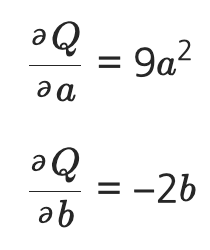

In [24]:
print(9*a**2 == a.grad)
print(-2*b == b.grad)

tensor([True, True])
tensor([True, True])


## 4.연산 그래프(Computational Graph)
개념적으로 autograd 텐서의 모든 연산들은 Function 객체로 구성된 방향성비순환그래프(DAG; Directed Acyclic Graph)에 저장된다. 여기서 DAG의 잎은 입력텐서고 root는 결과 텐서이다.

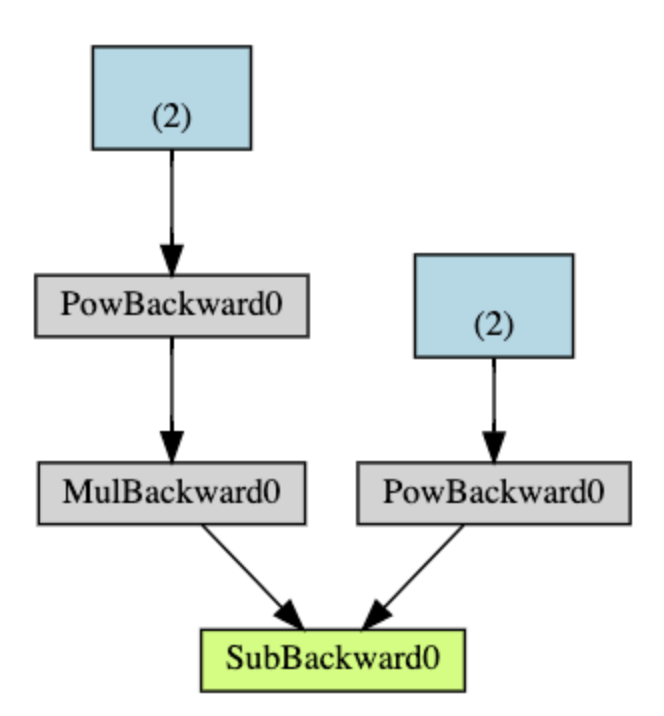

순전파와 역전파에서 내부적으로 다음이 진행된다.

* 순전파 : 
  * 연산을 수행하여 결과 텐서를 계산
* 역전파 : root에서 `.backward()`가 호출될 때 시작한다.
  * autograd는 각 `.grad_fn`으로부터 gradient계산 후 각텐서의 `.grad`속성에 계산 결과 쌓는다.(accumulate!!, 덮어쓰는게 아님)
  * 연쇄법칙을 사용하여 propagate한다.
  
  
참고: torch에서 DAG는 동적이다. 이는 그래프가 from stratch(처음부터) 다시 생성된다는 것이다. `.backward()`호출시 autograd는 새로운 그래프를 채운다. 이 덕분에 모델에서 흐름 제어 구문을 사용할 수 있는데, iteration 마다 필요시 모양, 크기, 연산을 바꿀 수 있다. 0ㅅ0 -> 파이프라인 만들때 필요시 구문을 바꿀 수 있다는 말인가보오?

### 4.1 DAG에서 제외
`requires_grad=False`를 이용하여 DAG gradient 계산에서 제외 가능하다.

In [25]:
# 입력 텐서 중 하나라도 requires_grad=T 면, 겨로가 텐서도 grad를 갖게 된다.

x = torch.rand(5, 5)
y = torch.rand(5, 5)
z = torch.rand((5, 5), requires_grad=True)

a = x + y
print(f"Does `a` require gradients? : {a.requires_grad}")
b = x + z
print(f"Does `b` require gradients?: {b.requires_grad}")

Does `a` require gradients? : False
Does `b` require gradients?: True


NN에서 gradient 계산하지 않는 매개변수를 frozen parameter 라고 부른다. 이렇게 필요시, 신경망의 frozen시키면 autograd 연산량을 줄임으로써 성능상(?)의 이득이 생김

적용 : 미리학습된 모델을 fintuning할때 일반적으로 모델의 대부분을 frozen시키고 classifier layer만 변경한다.

In [28]:
from torch import nn, optim
model = torchvision.models.resnet18(pretrained=True)

#! 외워!
for param in model.parameters():
    param.requires_grad = False

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [30]:
## 마지막 fc 만 새로운 레이어로 교체
## optimizer를 설정해도 gradient update는 classifier의 weight와 bias 뿐이다.
model.fc = nn.Linear(512, 10)
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

### 4.2 DAG 제외2 - context manager 방법
`with torch.no_grad()` 로 똑같이 제외 방법이 있다. 이 방법은 with 내부에서만 frozen하고 밖으로 나오면 다시 켜진다.

In [32]:
x= torch.tensor([1.], requires_grad=True)
with torch.no_grad():
    y = x * 2
print(y.requires_grad)

False


In [33]:
# 참고. flag사용법 : 함수에 사용
@torch.no_grad()
def doubler(x):
    return x * 2

z = doubler(x)
z.requires_grad

False